In [7]:
## Dependencies for semantic/neural search:
import numpy as np
!pip install sentence-transformers
# We use a pretrained model from https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')  # We can change it to a better model if we find one
import json
import re # for exact match
from nltk.stem import SnowballStemmer # for Finnish stemming
stemmer = SnowballStemmer("finnish")
import matplotlib.pyplot as plt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Please Enter your query, type 'quit' to exit:  yhtiöjärjestykseen


Your query "yhtiöjärjestykseen" matches 20 documents.
Here are the top 3 results:
Doc #1 (score: 0.3572): Title:
KKO:2025:9
Description:
A oli osakeyhtiön t
Doc #2 (score: 0.3417): Title:
KKO:2025:16
Description:
A oli toiminut osa
Doc #3 (score: 0.3257): Title:
KKO:2025:13
Description:
Osakeyhtiön yhtiök


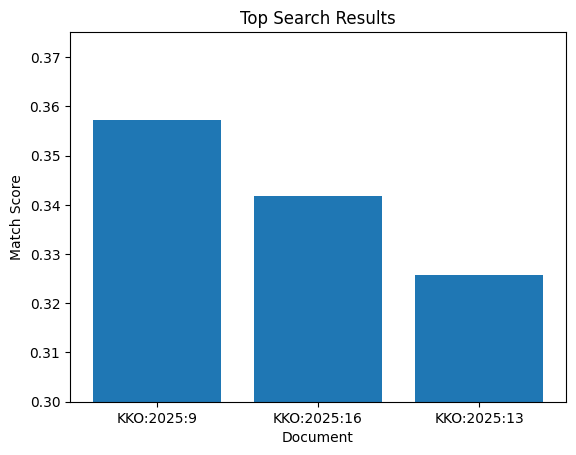

Please Enter your query, type 'quit' to exit:  quit


Exit


In [ ]:
def load_documents(file_path):
    documents = []
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
        
## This loop works on the sample database, but need to be modified if the keys change as the dadtabase develops
## The metadata and link parts are left out but can be added if needed
    for year, cases in data.items():
        for case_info in cases.values():  
            text_content = []
            
            if "Title" in case_info:
                text_content.append("Title:")  
                text_content.append(case_info["Title"])
            
            if "Description" in case_info:
                text_content.append("Description:")
                text_content.extend(case_info["Description"])
            
            for section in ["Asian käsittely alemmissa oikeuksissa", "Muutoksenhaku Korkeimmassa oikeudessa", "Korkeimman oikeuden ratkaisu"]:
                if section in case_info and "Contents" in case_info[section]:
                    text_content.append(f"\n{section}:")
                    text_content.extend(case_info[section]["Contents"])
            
            documents.append("\n".join(text_content))

    return documents

# Neural search function
def neural_search(documents, user_input):
    # Encode the documents and user query
    doc_embeddings = model.encode(documents)  # Encode documents
    query_embedding = model.encode(user_input)  # Encode user input
    
    # Calculate cosine similarities between the query and documents
    cosine_similarities = np.dot(query_embedding, doc_embeddings.T)  # Calculate cosine similarities
    ranked_doc_indices = np.argsort(cosine_similarities)[::-1]  # Rank hits (higher is better), Sort descending
    
    # Output the results (top 3 matches)
    num_results = min(3, len(documents))  # Limit to top 3 results
    print(f'Your query "{user_input}" matches {len(documents)} documents.')
    print(f"Here are the top {num_results} results:")

    # Collect results plotting
    result_scores = []
    result_titles = []
    
    for i in range(num_results):
        doc_idx = ranked_doc_indices[i]
        demo_doc = documents[doc_idx][:50]  # Display first 50 characters of the document content
        print(f"Doc #{i+1} (score: {cosine_similarities[doc_idx]:.4f}): {demo_doc}")

        # Extract the title from the document 
        doc_content = documents[doc_idx].split("\n")
        title = doc_content[0].replace("Title:", "").strip()  
        case_id = doc_content[1].strip()  
        
        # Construct title as 'Case ID: Title'
        full_title = f"{case_id}{title}"

        # Collect data for visualization
        result_scores.append(cosine_similarities[doc_idx])  # Store the similarity score
        result_titles.append(full_title)
    return result_scores, result_titles
    
def plotting(result_scores, result_titles):
    # Visualize the results
    plt.bar(result_titles, result_scores)
    plt.xlabel('Document')
    plt.ylabel('Match Score')
    plt.title('Top Search Results')
    plt.ylim(0.3)
    plt.show()



def user_query():
    print()
    user_input = input("Please Enter your query, type 'quit' to exit: ")
    return user_input

# tokenizer that applies stemming
def stem_tokenizer(text):
    tokens = re.findall(r'\b\w+\b', text.lower())  
    return [stemmer.stem(token) for token in tokens]  

# Function to process the query (exact match for quoted phrases, stemming for other tokens)
def process_query(query):
    tokens = []
    # This regex finds either "something in quotes" or individual words
    pattern = r'"(.*?)"|(\w+)'
    for match in re.finditer(pattern, query):
        if match.group(1):  # If token is in double quotes => exact match
            tokens.append((match.group(1).lower(), True))
        elif match.group(2):  # Otherwise, token is to be stemmed
            tokens.append((match.group(2).lower(), False))
    return tokens

def input_checker(user_input):
    if user_input == "quit" or user_input == "":
        print("Exit")
        return False
    return True



def main():

    file_path = 'sample_database.json'
    documents = load_documents(file_path)

    while True:
        user_input = user_query()
        if input_checker(user_input) == False: 
            break
            
        result_scores, result_titles = neural_search(documents, user_input)
        plotting(result_scores, result_titles)

# Run the main function
if __name__ == "__main__":
    main()